In [1]:
import torch
from torch import nn
from transformers import PreTrainedTokenizerFast, AutoTokenizer
from datasets import load_dataset
from evaluate import load, combine
from tqdm import tqdm

from transformer import *
from dataset import *

from numba import cuda
device = cuda.get_current_device()
device.reset() 

In [2]:
import sys
sys.path.append('../')
# from custom_tokenizers.tokenizerv1 import parse_sentence
import json

In [4]:
# get data 
train = load_dataset('csv', data_files='../data/train.csv')['train']
test = load_dataset('csv', data_files='../data/test.csv')['train']
VAL_CUTOFF = 500 # random choice for val loss, full test set is 3110, take 500 away for validation only. 
val = test[:VAL_CUTOFF]
test = test[VAL_CUTOFF:]

# obolo_tokenizer = PreTrainedTokenizerFast(tokenizer_file='../custom_tokenizers/obolo-bpe-tokenizer.json', padding='left')
english_tokenizer = AutoTokenizer.from_pretrained('gpt2', padding='left')

# from custom_tokenizers.tokenizerv2 import parse_sentence
from custom_tokenizers.dt_tokenizer import parse_sentence
# # we construct this vocab by calculating tokens from train data
# obolo_vocab_sents = [set(parse_sentence(s)) for s in train['Obolo']]
# obolo_vocab = set()
# for sent in obolo_vocab_sents:
#     obolo_vocab.update(sent)
# obolo_vocab = special_tokens + list(obolo_vocab)
# obolo_vocab = {token:idx for idx, token in enumerate(obolo_vocab)}

# # Serialize data into file:
# # json.dump( obolo_vocab, open( "../custom_tokenizers/custom_obolo_tokenizer_vocab_2.json", 'w' ) )
# json.dump( obolo_vocab, open( "../custom_tokenizers/custom_obolo_detokenizer_vocab.json", 'w' ) )


# Read data from file:
# obolo_vocab = json.load( open( "../custom_tokenizers/custom_obolo_tokenizer_vocab_2.json" ) )
obolo_vocab = json.load( open( "../custom_tokenizers/custom_obolo_detokenizer_vocab.json" ) )


print(len(obolo_vocab))
print(len(english_tokenizer.vocab))

print(DEVICE)

token_transform = {}
vocab_transform = {}

# token_transform[SRC_LANGUAGE] = parse_sentence
# token_transform[TGT_LANGUAGE] = english_tokenizer

# vocab_transform[SRC_LANGUAGE] = obolo_vocab 
# vocab_transform[TGT_LANGUAGE] = english_tokenizer.vocab

SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'ob'
token_transform[SRC_LANGUAGE] = english_tokenizer
token_transform[TGT_LANGUAGE] = parse_sentence

vocab_transform[SRC_LANGUAGE] = english_tokenizer.vocab 
vocab_transform[TGT_LANGUAGE] = obolo_vocab

# for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
#   vocab_transform[ln].set_default_index(UNK_IDX)
init_text_transform(token_transform, SRC_LANGUAGE, TGT_LANGUAGE)

# change this due to custom tokenizer
# init_text_transform(token_transform)
# text_transform[SRC_LANGUAGE] = sequential_transforms((lambda text: [obolo_vocab[token] if token in obolo_vocab else UNK_IDX for token in token_transform[SRC_LANGUAGE](text)]), # input to tokens to ids
#                                                      tensor_transform)                                                                                                          # add BOS/EOS and create tensor

# text_transform[TGT_LANGUAGE] = sequential_transforms((lambda text: token_transform[TGT_LANGUAGE](text).get('input_ids')),
#                                                      tensor_transform)    

text_transform[TGT_LANGUAGE] = sequential_transforms((lambda text: [obolo_vocab[token] if token in obolo_vocab else UNK_IDX for token in token_transform[TGT_LANGUAGE](text)]), # input to tokens to ids
                                                     tensor_transform)                                                                                                          # add BOS/EOS and create tensor

text_transform[SRC_LANGUAGE] = sequential_transforms((lambda text: token_transform[SRC_LANGUAGE](text).get('input_ids')),
                                                     tensor_transform)   

7165
50257
cuda
en ob


In [4]:
ob_sent, en_sent = train['Obolo'][0], train['English'][0]
print(ob_sent)
print(parse_sentence(ob_sent))
print(text_transform[SRC_LANGUAGE](ob_sent))
print([obolo_vocab[token] for token in token_transform[SRC_LANGUAGE](ob_sent)] == list(text_transform[SRC_LANGUAGE](ob_sent))[1:-1])
print(en_sent)
print(text_transform[TGT_LANGUAGE](en_sent))

eya orọ, nnenikana isi lek ogwukaan̄-ene awaji, mè ito ito inyi, mè iriaak uriaak, mè ibeek mbeek, mè ijin otu, mè itap ofọnti ufieejit, mè ifuun̄ lek me ntọn̄.
['e', 'ya', 'o', 'rọ', ',', 'n', 'neni', 'kana', 'i', 'si', 'lek', 'ogwukaan̄', '-', 'e', 'ne', 'awaji', ',', 'mè', 'i', 'to', 'i', 'to', 'i', 'nyi', ',', 'mè', 'i', 'riaak', 'uriaak', ',', 'mè', 'i', 'beek', 'm', 'beek', ',', 'mè', 'i', 'jin', 'o', 'tu', ',', 'mè', 'i', 'tap', 'ofọnti', 'ufieejit', ',', 'mè', 'i', 'fuun̄', 'lek', 'me', 'n', 'tọn̄', '.']
tensor([   1, 3663, 4948, 2148, 2510, 2491, 6404, 4761, 6466, 1347, 5593, 5110,
        5583, 2024, 3663, 1519, 3486, 2491, 3865, 1347, 1128, 1347, 1128, 1347,
         443, 2491, 3865, 1347, 5579,  136, 2491, 3865, 1347, 3847, 4775, 3847,
        2491, 3865, 1347, 3084, 2148, 1164, 2491, 3865, 1347, 6278, 5203, 6492,
        2491, 3865, 1347,  278, 5110, 3449, 6404, 2887, 6770,    2])
True
and i set my face unto the lord god, to seek by prayer and supplications, wi

In [9]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(obolo_vocab)
print(SRC_VOCAB_SIZE)
TGT_VOCAB_SIZE = english_tokenizer.vocab_size
# ORIGINAL TRANSFORMER CONFIGURATION
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 512
BATCH_SIZE = 64
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3

# TWEAKS ARE BAD, JUST USE DEFAULT CONFIG
# EMB_SIZE = 512
# NHEAD = 16
# FFN_HID_DIM = 512
# BATCH_SIZE = 64
# NUM_ENCODER_LAYERS = 6
# NUM_DECODER_LAYERS = 6

# train_dataloader = generate_dataloader(train['Obolo'], train['English'], BATCH_SIZE)
# val_dataloader = generate_dataloader(val['Obolo'], val['English'], BATCH_SIZE)
# test_dataloader = generate_dataloader(test['Obolo'], test['English'], BATCH_SIZE)
train_dataloader = generate_dataloader(train['English'], train['Obolo'], BATCH_SIZE)
val_dataloader = generate_dataloader(val['English'], val['Obolo'], BATCH_SIZE)
test_dataloader = generate_dataloader(test['English'], test['Obolo'], BATCH_SIZE)

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)
# optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0005, betas=(0.9, 0.98), eps=1e-9)

7150


c:\Users\abhiv\miniconda3\envs\cs224n-gpu\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [5]:
display(transformer)
display(optimizer)

Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerDecoderLayer(
          (self_attn): MultiheadAttent

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.98)
    capturable: False
    differentiable: False
    eps: 1e-09
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    weight_decay: 0
)

In [6]:
def train_epoch(model, optimizer):
    model.train()
    losses = 0

    for src, tgt in tqdm(train_dataloader):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)

        optimizer.zero_grad()

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward()

        optimizer.step()
        losses += loss.item()

        # save vram 
        del src, tgt
        torch.cuda.empty_cache()

    return losses / len(list(train_dataloader))


def evaluate(model):
    model.eval()
    losses = 0

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask, src_padding_mask, tgt_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()

        # save vram 
        del src, tgt
        torch.cuda.empty_cache()

    return losses / len(list(val_dataloader))

In [7]:
from timeit import default_timer as timer

# NUM_EPOCHS = 10
NUM_EPOCHS = 50 

train_losses = []
val_losses = []
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    if epoch % 5 == 0:
        torch.save(transformer, f'checkpoints/transformer_english_to_obolo_custom_{epoch}_epochs.pt')

  0%|          | 0/438 [00:00<?, ?it/s]c:\Users\abhiv\miniconda3\envs\cs224n-gpu\lib\site-packages\torch\nn\functional.py:5504: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
c:\Users\abhiv\miniconda3\envs\cs224n-gpu\lib\site-packages\torch\nn\functional.py:5137: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 438/438 [04:31<00:00,  1.61it/s]


Epoch: 1, Train loss: 5.795, Val loss: 4.473, Epoch time = 284.880s


100%|██████████| 438/438 [04:23<00:00,  1.66it/s]


Epoch: 2, Train loss: 4.188, Val loss: 3.871, Epoch time = 277.164s


100%|██████████| 438/438 [04:30<00:00,  1.62it/s]


Epoch: 3, Train loss: 3.739, Val loss: 3.526, Epoch time = 283.914s


100%|██████████| 438/438 [04:23<00:00,  1.66it/s]


Epoch: 4, Train loss: 3.433, Val loss: 3.289, Epoch time = 277.622s


100%|██████████| 438/438 [04:23<00:00,  1.66it/s]


Epoch: 5, Train loss: 3.198, Val loss: 3.108, Epoch time = 277.310s


100%|██████████| 438/438 [04:22<00:00,  1.67it/s]


Epoch: 6, Train loss: 3.006, Val loss: 2.964, Epoch time = 275.477s


100%|██████████| 438/438 [04:22<00:00,  1.67it/s]


Epoch: 7, Train loss: 2.843, Val loss: 2.853, Epoch time = 276.150s


100%|██████████| 438/438 [04:22<00:00,  1.67it/s]


Epoch: 8, Train loss: 2.701, Val loss: 2.762, Epoch time = 275.433s


100%|██████████| 438/438 [04:21<00:00,  1.67it/s]


Epoch: 9, Train loss: 2.576, Val loss: 2.688, Epoch time = 275.226s


100%|██████████| 438/438 [04:22<00:00,  1.67it/s]


Epoch: 10, Train loss: 2.464, Val loss: 2.641, Epoch time = 276.120s


100%|██████████| 438/438 [04:24<00:00,  1.66it/s]


Epoch: 11, Train loss: 2.363, Val loss: 2.594, Epoch time = 277.910s


100%|██████████| 438/438 [04:22<00:00,  1.67it/s]


Epoch: 12, Train loss: 2.270, Val loss: 2.555, Epoch time = 276.418s


100%|██████████| 438/438 [04:23<00:00,  1.66it/s]


Epoch: 13, Train loss: 2.181, Val loss: 2.530, Epoch time = 277.328s


100%|██████████| 438/438 [04:24<00:00,  1.65it/s]


Epoch: 14, Train loss: 2.104, Val loss: 2.486, Epoch time = 278.321s


100%|██████████| 438/438 [04:23<00:00,  1.66it/s]


Epoch: 15, Train loss: 2.029, Val loss: 2.449, Epoch time = 276.970s


100%|██████████| 438/438 [04:23<00:00,  1.67it/s]


Epoch: 16, Train loss: 1.958, Val loss: 2.441, Epoch time = 276.513s


100%|██████████| 438/438 [04:23<00:00,  1.66it/s]


Epoch: 17, Train loss: 1.895, Val loss: 2.430, Epoch time = 277.281s


100%|██████████| 438/438 [04:22<00:00,  1.67it/s]


Epoch: 18, Train loss: 1.834, Val loss: 2.410, Epoch time = 276.435s


100%|██████████| 438/438 [04:23<00:00,  1.66it/s]


Epoch: 19, Train loss: 1.773, Val loss: 2.397, Epoch time = 277.393s


100%|██████████| 438/438 [04:23<00:00,  1.66it/s]


Epoch: 20, Train loss: 1.711, Val loss: 2.402, Epoch time = 277.171s


100%|██████████| 438/438 [04:24<00:00,  1.66it/s]


Epoch: 21, Train loss: 1.658, Val loss: 2.427, Epoch time = 277.587s


100%|██████████| 438/438 [04:23<00:00,  1.66it/s]


Epoch: 22, Train loss: 1.607, Val loss: 2.424, Epoch time = 276.638s


100%|██████████| 438/438 [04:26<00:00,  1.65it/s]


Epoch: 23, Train loss: 1.556, Val loss: 2.417, Epoch time = 279.712s


100%|██████████| 438/438 [04:25<00:00,  1.65it/s]


Epoch: 24, Train loss: 1.504, Val loss: 2.427, Epoch time = 279.438s


100%|██████████| 438/438 [04:24<00:00,  1.65it/s]


Epoch: 25, Train loss: 1.457, Val loss: 2.421, Epoch time = 278.202s


100%|██████████| 438/438 [04:24<00:00,  1.65it/s]


Epoch: 26, Train loss: 1.412, Val loss: 2.442, Epoch time = 278.304s


100%|██████████| 438/438 [04:24<00:00,  1.65it/s]


Epoch: 27, Train loss: 1.370, Val loss: 2.455, Epoch time = 278.219s


100%|██████████| 438/438 [04:27<00:00,  1.64it/s]


Epoch: 28, Train loss: 1.326, Val loss: 2.462, Epoch time = 280.813s


100%|██████████| 438/438 [04:26<00:00,  1.64it/s]


Epoch: 29, Train loss: 1.283, Val loss: 2.491, Epoch time = 279.804s


100%|██████████| 438/438 [04:30<00:00,  1.62it/s]


Epoch: 30, Train loss: 1.247, Val loss: 2.508, Epoch time = 284.251s


100%|██████████| 438/438 [04:27<00:00,  1.64it/s]


Epoch: 31, Train loss: 1.208, Val loss: 2.527, Epoch time = 281.199s


100%|██████████| 438/438 [04:24<00:00,  1.65it/s]


Epoch: 32, Train loss: 1.171, Val loss: 2.555, Epoch time = 278.483s


100%|██████████| 438/438 [04:24<00:00,  1.66it/s]


Epoch: 33, Train loss: 1.137, Val loss: 2.550, Epoch time = 277.735s


100%|██████████| 438/438 [04:23<00:00,  1.66it/s]


Epoch: 34, Train loss: 1.102, Val loss: 2.571, Epoch time = 276.863s


100%|██████████| 438/438 [04:23<00:00,  1.66it/s]


Epoch: 35, Train loss: 1.067, Val loss: 2.586, Epoch time = 277.036s


100%|██████████| 438/438 [04:29<00:00,  1.63it/s]


Epoch: 36, Train loss: 1.035, Val loss: 2.598, Epoch time = 282.811s


100%|██████████| 438/438 [04:23<00:00,  1.66it/s]


Epoch: 37, Train loss: 1.003, Val loss: 2.627, Epoch time = 277.351s


100%|██████████| 438/438 [04:23<00:00,  1.66it/s]


Epoch: 38, Train loss: 0.971, Val loss: 2.646, Epoch time = 277.076s


100%|██████████| 438/438 [04:24<00:00,  1.66it/s]


Epoch: 39, Train loss: 0.941, Val loss: 2.671, Epoch time = 277.653s


100%|██████████| 438/438 [04:22<00:00,  1.67it/s]


Epoch: 40, Train loss: 0.913, Val loss: 2.698, Epoch time = 275.998s


100%|██████████| 438/438 [04:23<00:00,  1.66it/s]


Epoch: 41, Train loss: 0.885, Val loss: 2.719, Epoch time = 276.671s


100%|██████████| 438/438 [04:25<00:00,  1.65it/s]


Epoch: 42, Train loss: 0.860, Val loss: 2.736, Epoch time = 278.543s


100%|██████████| 438/438 [04:22<00:00,  1.67it/s]


Epoch: 43, Train loss: 0.832, Val loss: 2.770, Epoch time = 276.420s


100%|██████████| 438/438 [04:24<00:00,  1.65it/s]


Epoch: 44, Train loss: 0.806, Val loss: 2.772, Epoch time = 278.252s


100%|██████████| 438/438 [04:25<00:00,  1.65it/s]


Epoch: 45, Train loss: 0.782, Val loss: 2.779, Epoch time = 278.662s


100%|██████████| 438/438 [04:23<00:00,  1.66it/s]


Epoch: 46, Train loss: 0.761, Val loss: 2.817, Epoch time = 277.286s


100%|██████████| 438/438 [04:24<00:00,  1.65it/s]


Epoch: 47, Train loss: 0.735, Val loss: 2.833, Epoch time = 278.355s


100%|██████████| 438/438 [04:26<00:00,  1.65it/s]


Epoch: 48, Train loss: 0.712, Val loss: 2.855, Epoch time = 279.538s


100%|██████████| 438/438 [04:24<00:00,  1.66it/s]


Epoch: 49, Train loss: 0.691, Val loss: 2.879, Epoch time = 277.434s


100%|██████████| 438/438 [04:24<00:00,  1.66it/s]


Epoch: 50, Train loss: 0.670, Val loss: 2.911, Epoch time = 277.980s


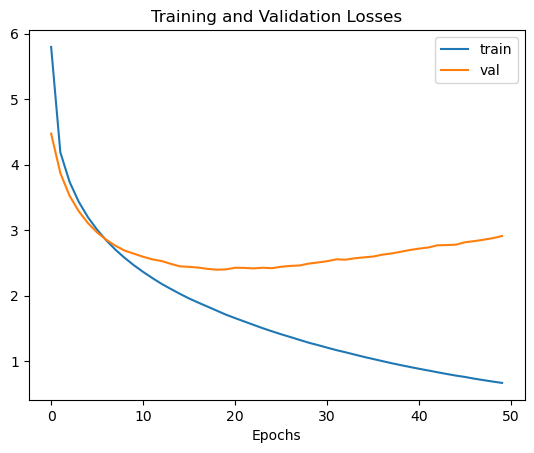

In [8]:
import matplotlib.pyplot as plt 
import numpy as np

plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.legend()
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.show()

In [29]:
torch.save(transformer.state_dict(), 'transformer_obolo_to_english_custom_dict.pt')

In [30]:
torch.save(transformer, 'transformer_obolo_to_english_custom.pt')

In [31]:
m=torch.load('transformer_obolo_to_english_custom.pt')
m

Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerDecoderLayer(
          (self_attn): MultiheadAttent

In [12]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        # print(out)
        # print(english_tokenizer.decode(out))
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()
        # print(next_word)
        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        # save vram
        del tgt_mask
        torch.cuda.empty_cache()
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    
    return token_transform[TGT_LANGUAGE].decode(tgt_tokens[1:-1])
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("[CLS]", "").replace("[SEP]", "")


In [35]:
# src_sentence = "ire, emi okumugwem mâtap oke me etete anam ebi ijeren mè echi ebi ijipiti. anam geege me etete echi ebi ijeren ìkpokwu"
# src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
# print(list(src.numpy().flatten()), src.shape)
# print(token_transform[SRC_LANGUAGE].decode(src.numpy().flatten()))

In [41]:
ob, en = test['Obolo'][100], test['English'][100]
print(ob)
print(translate(m, ob))
print(en)

mgbọ yaage îmun̄be ife chi egwookbe, ibebene ikaan̄ ulọk me lek kiban̄, mè iria osat isi lek kiban̄ me kalidia.
and it came to pass, when they saw that they had seen, that they sent to the sea, and sent them to the chaldeans, and sent to the chaldeans.
and as soon as she saw them with her eyes, she doted upon them, and sent messengers unto them into chaldea.


In [10]:
sentence = "ogwu ubọọn̄ oneniyaka ido siba ibe, “sà gwun̄ nte uwu kwun̄ ìkup me owa?” siba ofọfọọk ibe ke ọmọ òwa me jeruselem okupbe, mije, ìkikeek ibe, usini mgbọ, cherekeyi, ke ebi uwu kè ijeren mêniyaka irek mkpulu nte nte kan̄ inyi ọmọ."

ob_train_sent = "ogwu ubọọn̄ oneniyaka ido siba ibe, “sà gwun̄ nte uwu kwun̄ ìkup me owa?” siba ofọfọọk ibe ke ọmọ òwa me jeruselem okupbe, mije, ìkikeek ibe, usini mgbọ, cherekeyi, ke ebi uwu kè ijeren mêniyaka irek mkpulu nte nte kan̄ inyi ọmọ."
en_train_sent = "and the king said, and where [is] thy master’s son? and ziba said unto the king, behold, he abideth at jerusalem: for he said, to day shall the house of israel restore me the kingdom of my father."
print(en_train_sent)
print(translate(transformer, ob_train_sent))
ob_test_sent = "eyi nnyibe ebi nte nte kinyi ida ibe esun̄, mgbọ nsan̄abe ema isibi me ijipiti, me emen ukan̄ ikala okwukwut.” mgbọ ya, ntumu inyi ema ibe, “ìgban̄ utọn̄ me ida n̄a, mè ìrọ inu geelek ntọbe inyi enyi, ke enyi mêre ebi n̄a, emi nrere awaji kinyi."
en_test_sent = "which i commanded your fathers in the day [that] i brought them forth out of the land of egypt, from the iron furnace, saying, obey my voice, and do them, according to all which i command you: so shall ye be my people, and i will be your god:"
print(en_test_sent)
print(translate(transformer, ob_test_sent))
print(translate(transformer, 'Jisọs'))

and the king said, and where [is] thy master’s son? and ziba said unto the king, behold, he abideth at jerusalem: for he said, to day shall the house of israel restore me the kingdom of my father.
and the king said unto the woman, how [is] this thy son, that he may be done unto this house of israel? and he said, nay; for the son of man, i will surely rend the kingdom from the kingdom of israel.
which i commanded your fathers in the day [that] i brought them forth out of the land of egypt, from the iron furnace, saying, obey my voice, and do them, according to all which i command you: so shall ye be my people, and i will be your god:
and i have made my covenant with your fathers in egypt, and i have made an end of speaking unto them: i have not commanded them that they should make my two eyes to be my gods.
blessed [are]


MAKE TRANSLATE ACTUALLY WORK !!!

In [13]:
test = load_dataset('csv', data_files='../data/test.csv')['train']
print(len(test))

3110


In [14]:
chrf = load('chrf')
gleu = load('google_bleu')
rouge = load('rouge') 
bleu = load('bleu')
meteor = load('meteor')
metrics = combine([chrf, bleu, rouge, meteor, gleu])

def test_model(m):
    preds = []
    refs = []
    for idx in tqdm(range(len(test['Obolo']))):
        ob, en = test['Obolo'][idx], test['English'][idx]
        refs.append(en)
        pred = translate(m, ob)
        preds.append(pred)
    print(len(preds), len(refs))
    chrf_plusplus = chrf.compute(predictions=preds, references=refs, word_order=2)
    other_metrics = metrics.compute(predictions=preds, references=refs)
    return (chrf_plusplus, other_metrics)

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [15]:
models = []
for epoch in [10,20,30,40,50]:
    model = torch.load(f'checkpoints/transformer_obolo_to_english_custom2_{epoch}_epochs.pt').to(DEVICE)
    models.append(model)
display(models[0])
scores = []
for mod in models:
    score = test_model(mod)
    display(score)
    scores.append(score) 

RuntimeError: CUDA error: invalid argument
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [8]:
scores

[({'score': 33.14887289176948, 'char_order': 6, 'word_order': 2, 'beta': 2},
  {'score': 33.94522941130094,
   'char_order': 6,
   'word_order': 0,
   'beta': 2,
   'bleu': 0.10615131528855178,
   'precisions': [0.37927541956589994,
    0.1489445814217201,
    0.06685701453273876,
    0.03361825242291234],
   'brevity_penalty': 1.0,
   'length_ratio': 1.2276101309261815,
   'translation_length': 98733,
   'reference_length': 80427,
   'rouge1': 0.37320652389898057,
   'rouge2': 0.1430445557839643,
   'rougeL': 0.316166689351148,
   'rougeLsum': 0.31598264093105866,
   'meteor': 0.32309606902943644,
   'google_bleu': 0.15597258118889762}),
 ({'score': 36.58625994321825, 'char_order': 6, 'word_order': 2, 'beta': 2},
  {'score': 37.60193081439757,
   'char_order': 6,
   'word_order': 0,
   'beta': 2,
   'bleu': 0.13759957722373378,
   'precisions': [0.42630054656707966,
    0.18309874938365683,
    0.09121972617920716,
    0.050347552847076746],
   'brevity_penalty': 1.0,
   'length_ratio

In [7]:
orig_10_epoch_custom = torch.load('transformer_obolo_to_english_custom.pt').to(DEVICE)
score = test_model(orig_10_epoch_custom)
display(score)

100%|██████████| 2610/2610 [08:42<00:00,  5.00it/s]


2610 2610


{'score': 33.6596090739384,
 'char_order': 6,
 'word_order': 0,
 'beta': 2,
 'bleu': 0.11152622811206186,
 'precisions': [0.3960213311587283,
  0.15589433362402993,
  0.07046159791763756,
  0.0355636772561147],
 'brevity_penalty': 1.0,
 'length_ratio': 1.1587775249605232,
 'translation_length': 93197,
 'reference_length': 80427,
 'rouge1': 0.378588728210996,
 'rouge2': 0.14502504247389858,
 'rougeL': 0.32141031622794514,
 'rougeLsum': 0.32135055941369345,
 'meteor': 0.32787793097157697,
 'google_bleu': 0.16055082533221088}

In [13]:
print(len(preds), len(refs))

2610 2610


In [14]:
# metrics
chrf = load('chrf')
gleu = load('google_bleu')
rouge = load('rouge') 
bleu = load('bleu')
meteor = load('meteor')
metrics = combine([chrf, bleu, rouge, meteor, gleu])

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\abhiv\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [15]:
scores = metrics.compute(predictions=preds, references=refs)
scores

{'score': 30.43952826900615,
 'char_order': 6,
 'word_order': 0,
 'beta': 2,
 'bleu': 0.0822760096610319,
 'precisions': [0.34278131844280896,
  0.11676725534672716,
  0.04780428948846498,
  0.023949022794337766],
 'brevity_penalty': 1.0,
 'length_ratio': 1.2602981585785868,
 'translation_length': 101362,
 'reference_length': 80427,
 'rouge1': 0.3352499302267455,
 'rouge2': 0.11275906915007564,
 'rougeL': 0.27644615250839405,
 'rougeLsum': 0.2763975206470654,
 'meteor': 0.28851067939375274,
 'google_bleu': 0.13259436788496107}